In [180]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches
import json
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')
df = df.loc[df.source_device_type == 'Mite']
df = df.loc[df.target_device_type == 'Mite']

df['replica'] = ['Same device' if row['source_device'] == row['target_device'] else 'Replica' for i, row in df.iterrows()]

print(df.type_of_transfer.unique())

df_no_transfer = df.loc[df.type_of_transfer == 'No transfer']

df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'Same room, same place',
    'Same device type in different place': 'Same room, different place',
    'Same device in different place': 'Same room, different place',
    'Same device type across spaces': 'Different room',
    'Same device across spaces': 'Different room',
    'Same device in same place': '__remove__',
    'No transfer': 'No transfer'
})

df = df.loc[df.type_of_transfer != '__remove__']

['No transfer' 'Same device type in different place'
 'Same device across spaces' 'Same device type across spaces'
 'Same device in different place' 'Same device type in same place'
 'Same device in same place']


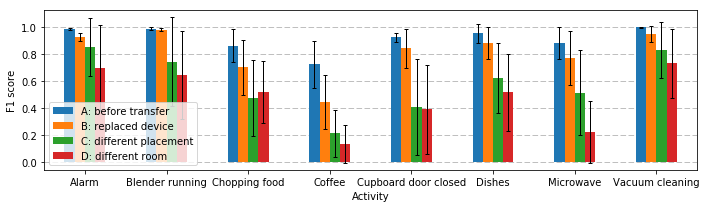

In [241]:
plt.rcParams["figure.figsize"] = (10, 3)

value_column = 'f1'

df_plot = df.loc[df.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]
df_plot = df_plot.loc[df_plot.features_name == 'All']
df_plot = df_plot.loc[df_plot.classifier == 'SVM']

df_plot = df_plot.replace('No transfer', 'A: before transfer')
df_plot = df_plot.replace('Same room, same place', 'B: replaced device')
df_plot = df_plot.replace('Same room, different place', 'C: different placement')
df_plot = df_plot.replace('Different room', 'D: different room')

means = df_plot.groupby(['label', 'type_of_transfer'])[value_column].mean()
means = means.reset_index()
means = means.rename(columns={'label': 'Activity', 'type_of_transfer': 'Transfer type'})
means = means.pivot(index='Activity', columns='Transfer type', values=value_column)

errors = df_plot.groupby(['label', 'type_of_transfer'])[value_column].std()
errors = errors.reset_index()
errors = errors.rename(columns={'label': 'Activity', 'type_of_transfer': 'Transfer type'})
errors = errors.pivot(index='Activity', columns='Transfer type', values=value_column)

ax = means.plot.bar(yerr=errors,
              error_kw=dict(lw=1, capsize=2, capthick=1))
ax.set_axisbelow(True)
ax.yaxis.grid(linestyle='dashed',)
plt.legend(loc=3)
plt.ylabel('F1 score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../plots/performance_by_activities_transfer.pdf')
plt.show()

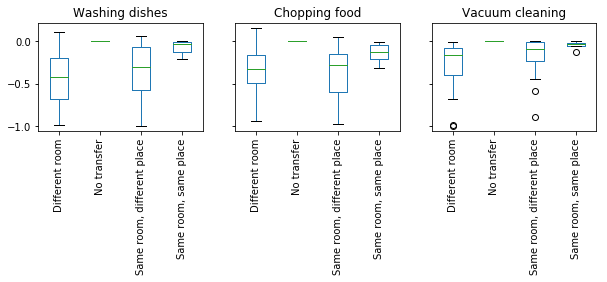

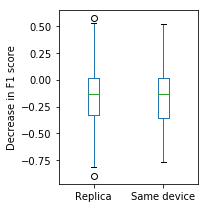

In [245]:
plt.rcParams["figure.figsize"] = (10, 2)

features = 'All'
label = 'Dishes'
value_column = 'f1_change'
classifier = 'SVM'

f, axes = plt.subplots(1, 3, sharex=False, sharey=True)

boxplot_by('type_of_transfer',
           value_column=value_column, label='Dishes', features=features, classifier=classifier,
           title='Washing dishes', ax=axes[0],
           df_plot=df)

boxplot_by('type_of_transfer',
           value_column=value_column, label='Chopping food', features=features, classifier=classifier,
           title='Chopping food', ax=axes[1],
           df_plot=df)

boxplot_by('type_of_transfer',
           value_column=value_column, label='Vacuum cleaning', features=features, classifier=classifier,
           title='Vacuum cleaning', ax=axes[2],
           df_plot=df)

plt.rcParams["figure.figsize"] = (3, 3)

_df = df.loc[(df.source_placement != df.target_placement) & (df.source_room == df.target_room)]
_df = _df.loc[_df.f1_change < 0.6]

boxplot_by('replica',
           value_column='f1_change', label=None, features=features, classifier='LogisticRegression',
           title='',
           df_plot=_df)
plt.ylabel('Decrease in F1 score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../plots/replica_across_placements.pdf')
plt.show()

/home/giotto/.local/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


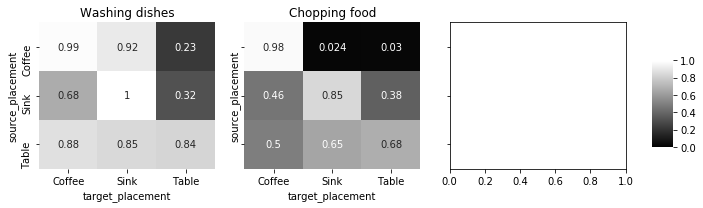

In [10]:
value_column = 'f1'

df_within_space = df.loc[df.source_room == df.target_room]
df_within_space = df_within_space.loc[df_within_space.source_placement != df_within_space.target_placement]
df_within_space = pd.concat([df_within_space, df_no_transfer])
df_within_space = df_within_space.loc[df_within_space.source_room == 'synergy']
df_within_space = df_within_space.loc[df_within_space.source_dataset == df_within_space.target_dataset]
df_within_space = df_within_space.loc[df_within_space.source_dataset == 'synergy-final-iter2']

plt.rcParams["figure.figsize"] = (10, 3)

fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

features = 'All'
classifier = 'SVM'

heatmap_by('target_placement', 'source_placement', value_column, label='Dishes',
           title='Washing dishes',
           ax=axes[0],
           draw_cbar=True,
           cbar_ax=cbar_ax,
           vmin=0, vmax=1,
           features=features, classifier=classifier, df_plot=df_within_space)

heatmap_by('target_placement', 'source_placement', value_column, label='Chopping food',
           title='Chopping food',
           draw_cbar=False,
           cbar_ax=None,
           ax=axes[1],
           vmin=0, vmax=1,
           features=features, classifier=classifier, df_plot=df_within_space)

# show double rows, one for synergy, one for scott

# heatmap_by('target_placement', 'source_placement', value_column, label='Vacuum cleaning',
#            title='Vacuum cleaning',
#            draw_cbar=False,
#            cbar_ax=None,
#            ax=axes[2],
#            vmin=0, vmax=1,
#            features=features, classifier=classifier, df_plot=df_within_space)

fig.tight_layout(rect=[0, 0, .9, 1])

/home/giotto/.local/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


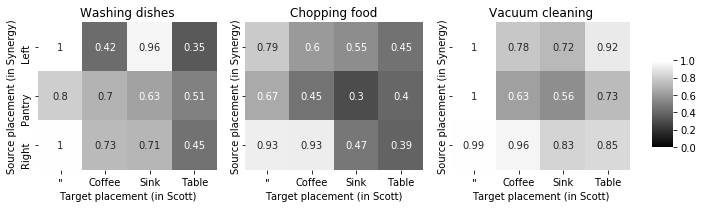

In [22]:
value_column = 'f1'

df_across_space = df.loc[df.source_room != df.target_room]
df_across_space = pd.concat([df_across_space, df_no_transfer])

plt.rcParams["figure.figsize"] = (10, 3)

fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

features = 'All'
classifier = 'SVM'

source_room = 'scott'
target_room = 'synergy'

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot_no_transfer = df_no_transfer.loc[df_no_transfer.source_room == source_room].copy()
df_plot_no_transfer['target_placement'] = '"'

df_plot = pd.concat([
    df_plot,
    df_plot_no_transfer
])

x_column = 'Target placement (in Scott)'
y_column = 'Source placement (in Synergy)'

df_plot = df_plot.rename(columns={
    'source_placement': y_column,
    'target_placement': x_column,
})

heatmap_by(x_column, y_column, value_column, label='Dishes',
           title='Washing dishes',
           draw_cbar=True,
           cbar_ax=cbar_ax,
           vmin=0, vmax=1,
           ax=axes[0],
           features=features, classifier=classifier, df_plot=df_plot)

heatmap_by(x_column, y_column, value_column, label='Chopping food',
           title='Chopping food',
           draw_cbar=False,
           cbar_ax=None,
           vmin=0, vmax=1,
           ax=axes[1],
           features=features, classifier=classifier, df_plot=df_plot)

heatmap_by(x_column, y_column, value_column, label='Vacuum cleaning',
           title='Vacuum cleaning',
           draw_cbar=False,
           cbar_ax=None,
           vmin=0, vmax=1,
           ax=axes[2],
           features=features, classifier=classifier, df_plot=df_plot)

fig.tight_layout(rect=[0, 0, .9, 1])

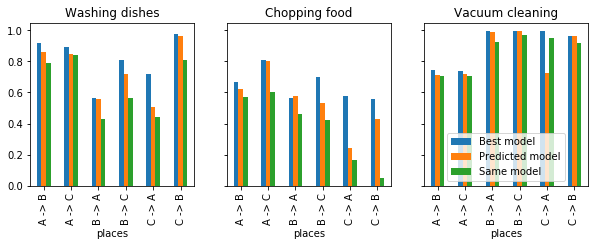

In [202]:
def rename_labels(df_plot, column):
    df_plot[column] = df_plot[column].replace('Coffee', 'C')
    df_plot[column] = df_plot[column].replace('Sink', 'B')
    df_plot[column] = df_plot[column].replace('Table', 'A')
    return df_plot

def to_series(df_plot, label):
    df_plot = rename_labels(df_plot, 'source_placement')
    df_plot = rename_labels(df_plot, 'target_placement')
    df_plot = df_plot.loc[df_plot.source_placement != df_plot.target_placement]
    df_plot = df_plot.loc[df_plot.source_device_type == 'Mite']
    df_plot = df_plot.loc[df_plot.target_device_type == 'Mite']
    df_plot = df_plot.loc[(df_plot.source_room == 'synergy') & (df_plot.target_room == 'synergy')]
    df_plot = df_plot.loc[df_plot.label == label]
    df_plot['places'] = df_plot['source_placement'] + ' -> ' + df_plot['target_placement']
    return df_plot.groupby('places')['f1'].mean()


only_best = df
only_best = only_best.sort_values(by='f1', ascending=False)
only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

classified = pd.read_pickle('results_with_accuracy_classified.p')
classified = classified.loc[classified.predictions > 0]
classified = classified.sort_values(by='specificity', ascending=False)
classified = classified.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

df_within_space = df
df_within_space = df_within_space.loc[df_within_space.features_name == 'All']
df_within_space = df_within_space.loc[df_within_space.classifier == 'SVM']

plt.rcParams["figure.figsize"] = (10, 3)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)

pd.DataFrame({
    'Best model': to_series(only_best, 'Dishes'),
    'Predicted model': to_series(classified, 'Dishes'),
    'Same model': to_series(df_within_space, 'Dishes')
}).plot.bar(ax=axes[0])
matplotlib.pyplot.sca(axes[0])
axes[0].legend().set_visible(False)
plt.title('Washing dishes')

pd.DataFrame({
    'Best model': to_series(only_best, 'Chopping food'),
    'Predicted model': to_series(classified, 'Chopping food'),
    'Same model': to_series(df_within_space, 'Chopping food')
}).plot.bar(ax=axes[1])
matplotlib.pyplot.sca(axes[1])
axes[1].legend().set_visible(False)
plt.title('Chopping food')

pd.DataFrame({
    'Best model': to_series(only_best, 'Vacuum cleaning'),
    'Predicted model': to_series(classified, 'Vacuum cleaning'),
    'Same model': to_series(df_within_space, 'Vacuum cleaning')
}).plot.bar(ax=axes[2])
matplotlib.pyplot.sca(axes[2])
plt.title('Vacuum cleaning')

In [192]:
df_plot = pd.read_pickle('results_with_accuracy_classified.p')
df_plot = df_plot.loc[(df_plot.source_device_type == 'Mite') & (df_plot.target_device_type == 'Mite')]
df_plot = df_plot.loc[df_plot.predictions == 1]
df_plot = df_plot.loc[df_plot.specificity >= 0.95]
df_plot = df_plot.sort_values(by='specificity', ascending=False)
df_plot = df_plot.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

df_boxplot = pd.DataFrame()
df_boxplot = pd.concat([pd.DataFrame({'Predicted model': df_plot.f1}), df_boxplot], axis=1)

In [193]:
df_plot = df.loc[df.features_name == 'All']
df_plot = df_plot.loc[df_plot.classifier == 'SVM']
df_plot = df_plot.loc[df_plot.specificity >= 0.95]
df_plot = df_plot.sort_values(by='specificity', ascending=False)
df_plot = df_plot.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

df_boxplot = pd.concat([pd.DataFrame({'Same model': df_plot.f1}), df_boxplot], axis=1)

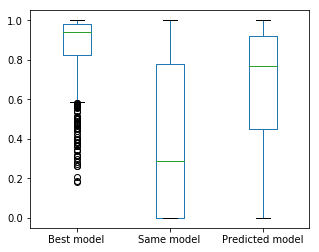

In [194]:
df_plot = df
df_plot = df_plot.loc[df_plot.specificity >= 0.95]
df_plot = df_plot.loc[df_plot.recall >= 0.7]
df_plot = df_plot.sort_values(by='f1', ascending=False)
df_plot = df_plot.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

df_boxplot = pd.concat([pd.DataFrame({'Best model': df_plot.f1}), df_boxplot], axis=1)

plt.rcParams["figure.figsize"] = (5, 4)

df_boxplot.plot.box()

In [15]:
plt.rcParams["figure.figsize"] = (10, 3)

def to_keys(df, dataset_col='source_dataset', device_col='source_device'):
    return df[dataset_col] + df[device_col] + df['label'] + df['classifier'] + df['features']


def scatter_with_3_dims(df_plot, label, title, ax=None, show_y_label=True, use_colors={}, use_markers={}, show_legend=False, classifier='LogisticRegression', features='All'):
    plot_df = df_plot.loc[df_plot['label'] == label]
    plot_df = plot_df.loc[plot_df.classifier == classifier]
    plot_df = plot_df.loc[plot_df.features_name == features]

    markers_df = pd.DataFrame({
        'from': plot_df['source_placement'],
        'to': plot_df['target_placement'],
        'value': plot_df['f1'],
        'position': 1,
        'connect_before': to_keys(plot_df),
        'connect_after': to_keys(plot_df, 'target_dataset', 'target_device')
    })

    no_transfer_keys = to_keys(df_no_transfer)
    no_transfer_keys = no_transfer_keys.drop_duplicates()
    no_transfer_keys = pd.Series(no_transfer_keys.index.values, index=no_transfer_keys)

    used_keys_source = to_keys(plot_df).unique()
    used_keys_target = to_keys(plot_df, 'target_dataset', 'target_device').unique()

    use_colors, use_markers, _ = scatter_plot_by('from', other_column='to',
                        x_value_column='position', y_value_column='value',
                        features=None,
                        classifier=None,
                        label=None,
                        common_limits=False,
                        show_legend=show_legend,
                        xlabel='',
                        ylabel='F1 score' if show_y_label else '',
                        ax=ax,
                        title=title,
                        use_colors=use_colors, use_markers=use_markers,
                        size=0,
                        df_plot=markers_df)

    for key in used_keys_source:
        from_f1 = df_no_transfer['f1'][no_transfer_keys[key]]
        for i, row in markers_df.loc[markers_df.connect_before == key].iterrows():
            to_f1 = row['value']
            plt.plot([0, 1], [from_f1, to_f1],
                     linewidth=3.0,
                     color=use_colors[row['from']], zorder=-100)

    for key in used_keys_target:
        to_f1 = df_no_transfer['f1'][no_transfer_keys[key]]
        for i, row in markers_df.loc[markers_df.connect_after == key].iterrows():
            from_f1 = row['value']
            plt.plot([1, 2], [from_f1, to_f1],
                     linewidth=3.0,
                     color=use_colors[row['to']], zorder=-100)

    plt.xticks([0, 1, 2], ['Source', 'Transfer', 'Target'])
    return use_colors, use_markers


'OK'

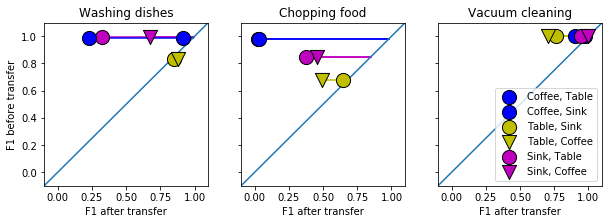

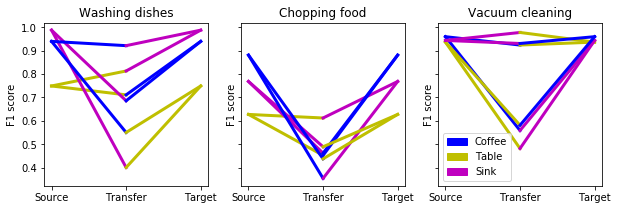

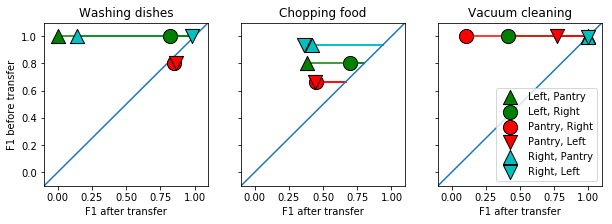

In [27]:
plt.rcParams["figure.figsize"] = (10, 3)

x_value_column='f1'
y_value_column='f1_wt'

df_within_space = df.loc[df.source_room == df.target_room]
df_within_space = df_within_space.loc[df_within_space.source_room == 'synergy']
df_within_space = df_within_space.loc[df_within_space.source_dataset == df_within_space.target_dataset]
df_within_space = df_within_space.loc[df_within_space.source_dataset == 'synergy-final-iter2']

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
_fig, _axes = plt.subplots(1, 3, sharex=True, sharey=True)

def create_scatter(df_plot, ax, label, title, show_y_label=True, use_colors={}, use_markers={}, show_legend=False):

    use_colors, use_markers, df_plot = scatter_plot_by('source_placement', other_column='target_placement',
                    x_value_column=x_value_column, y_value_column=y_value_column,
                    features='All',
                    classifier='SVM',
                    common_limits=True,
                    show_legend=show_legend,
                    min_val=-0.1, max_val=1.1,
                    title=title,
                    ax=ax,
                    use_colors=use_colors, use_markers=use_markers,
                    xlabel='F1 after transfer',
                    ylabel='F1 before transfer' if show_y_label else '',
                    label=label, df_plot=df_plot)
    
    for _, row in df_plot.iterrows():
        plt.plot([row['f1'], row['f1_wt']], [row['f1_wt'], row['f1_wt']], color=use_colors[row['source_placement']], zorder=-100)

    return use_colors, use_markers

use_colors, use_markers = create_scatter(df_within_space, axes[0], 'Dishes', 'Washing dishes', True, use_colors=use_colors, use_markers=use_markers)
use_colors, use_markers = scatter_with_3_dims(df_within_space, label='Dishes', title='Washing dishes', ax=_axes[0], use_colors=use_colors, use_markers=use_markers, show_y_label=True)

use_colors, use_markers = create_scatter(df_within_space, axes[1], 'Chopping food', 'Chopping food', False, use_colors, use_markers)
use_colors, use_markers = scatter_with_3_dims(df_within_space, label='Chopping food', title='Chopping food', ax=_axes[1], use_colors=use_colors, use_markers=use_markers)

df_within_space = df.loc[df.source_room == df.target_room]
df_within_space = df_within_space.loc[df_within_space.source_room == 'synergy']
df_within_space = df_within_space.loc[df_within_space.source_dataset == df_within_space.target_dataset]
df_within_space = df_within_space.loc[df_within_space.source_dataset == 'synergy-final-iter5']

use_colors, use_markers = create_scatter(df_within_space, axes[2], 'Vacuum cleaning', 'Vacuum cleaning', False, use_colors, use_markers, True)
use_colors, use_markers = scatter_with_3_dims(df_within_space, label='Vacuum cleaning', title='Vacuum cleaning', ax=_axes[2], use_colors=use_colors, use_markers=use_markers, show_legend=False)
patches = []
for placement in df_within_space['source_placement'].unique():
    patches.append(mpatches.Patch(color=use_colors[placement], label=placement))
plt.legend(handles=patches)

axes[2].legend(loc=4)


fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)

df_within_space = df.loc[df.source_room == df.target_room]
df_within_space = df_within_space.loc[df_within_space.source_room == 'scott']
# df_within_space = df_within_space.loc[df_within_space.source_dataset == df_within_space.target_dataset]
# df_within_space = df_within_space.loc[df_within_space.source_dataset == 'scott-final-iter1']

use_colors, use_markers = create_scatter(df_within_space, axes[0], 'Dishes', 'Washing dishes', True, use_colors, use_markers)

use_colors, use_markers = create_scatter(df_within_space, axes[1], 'Chopping food', 'Chopping food', False, use_colors, use_markers)

df_within_space = df.loc[df.source_room == df.target_room]
df_within_space = df_within_space.loc[df_within_space.source_room == 'scott']
# df_within_space = df_within_space.loc[df_within_space.source_dataset == df_within_space.target_dataset]
# df_within_space = df_within_space.loc[df_within_space.source_dataset == 'scott-final-iter1']

use_colors, use_markers = create_scatter(df_within_space, axes[2], 'Vacuum cleaning', 'Vacuum cleaning', False, use_colors, use_markers, True)


axes[2].legend(loc=4)
'OK'

In [23]:
use_colors = {'Coffee': 'b',
 'Left': 'g',
 'Pantry': 'r',
 'Right': 'c',
 'Sink': 'm',
 'Table': 'y'}

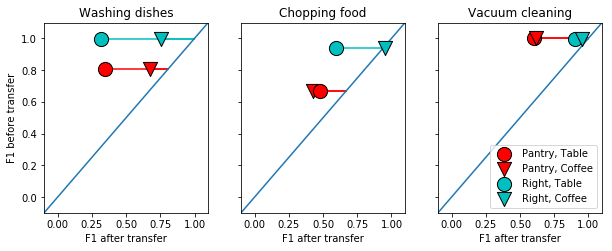

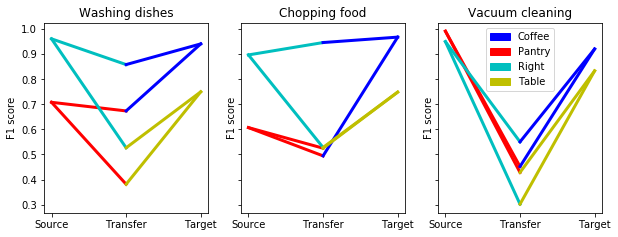

In [24]:
value_column = 'f1'

df_across_space = df.loc[df.source_room != df.target_room]

df_across_space = df_across_space.loc[df_across_space.target_placement != 'Sink']
df_across_space = df_across_space.loc[df_across_space.source_placement != 'Left']

plt.rcParams["figure.figsize"] = (10, 3.5)

features = 'All'
classifier = 'SVM'

source_room = 'scott'
target_room = 'synergy'

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot = df_plot.loc[df_plot.target_dataset == 'synergy-final-iter2']

fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)
_fig, _axes = plt.subplots(1, 3, sharex=True, sharey=True)

use_colors, use_markers = create_scatter(df_plot, axes[0], 'Dishes', 'Washing dishes', True, use_colors=use_colors, use_markers=use_markers)
use_colors, use_markers = scatter_with_3_dims(df_plot, label='Dishes', title='Washing dishes', ax=_axes[0], use_colors=use_colors, use_markers=use_markers, show_y_label=True)

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot = df_plot.loc[df_plot.target_dataset == 'synergy-final-iter1']

use_colors, use_markers = create_scatter(df_plot, axes[1], 'Chopping food', 'Chopping food', False, use_colors=use_colors, use_markers=use_markers)
use_colors, use_markers = scatter_with_3_dims(df_plot, label='Chopping food', title='Chopping food', ax=_axes[1], use_colors=use_colors, use_markers=use_markers)

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot = df_plot.loc[df_plot.target_dataset == 'synergy-final-iter4']

use_colors, use_markers = create_scatter(df_plot, axes[2], 'Vacuum cleaning', 'Vacuum cleaning', False, use_colors=use_colors, use_markers=use_markers, show_legend=True)
use_colors, use_markers = scatter_with_3_dims(df_plot, label='Vacuum cleaning', title='Vacuum cleaning', ax=_axes[2], use_colors=use_colors, use_markers=use_markers, show_legend=False)
patches = []
for placement in np.unique(df_plot.source_placement.values.tolist() + df_plot.target_placement.values.tolist()):
    patches.append(mpatches.Patch(color=use_colors[placement], label=placement))
plt.legend(handles=patches)
# plt.legend(loc='upper center', bbox_to_anchor=(1.4,0.9))

axes[2].legend(loc=4)

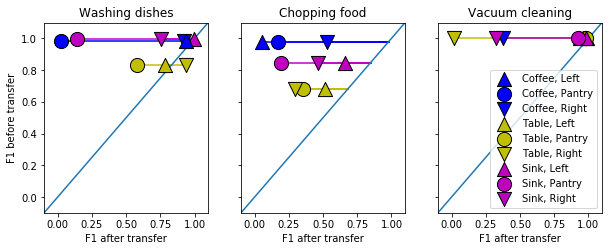

In [16]:
value_column = 'f1'

df_across_space = df.loc[df.source_room != df.target_room]
df_across_space = pd.concat([df_across_space, df_no_transfer])

plt.rcParams["figure.figsize"] = (10, 3.5)

features = 'All'
classifier = 'SVM'

target_room = 'scott'
source_room = 'synergy'

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot = df_plot.loc[df_plot.source_dataset == 'synergy-final-iter2']

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

use_colors, use_markers = create_scatter(df_plot, axes[0], 'Dishes', 'Washing dishes', True, use_colors, use_markers)

df_across_space = df.loc[df.source_room != df.target_room]
df_across_space = pd.concat([df_across_space, df_no_transfer])

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot = df_plot.loc[df_plot.source_dataset == 'synergy-final-iter2']

use_colors, use_markers = create_scatter(df_plot, axes[1], 'Chopping food', 'Chopping food', False, use_colors, use_markers)

df_across_space = df.loc[df.source_room != df.target_room]
df_across_space = pd.concat([df_across_space, df_no_transfer])

df_plot = df_across_space.loc[(df_across_space.source_room == source_room) & (df_across_space.target_room == target_room)]
df_plot = df_plot.loc[df_plot.source_dataset == 'synergy-final-iter5']

use_colors, use_markers = create_scatter(df_plot, axes[2], 'Vacuum cleaning', 'Vacuum cleaning', False, use_colors, use_markers, True)

axes[2].legend(loc=4)

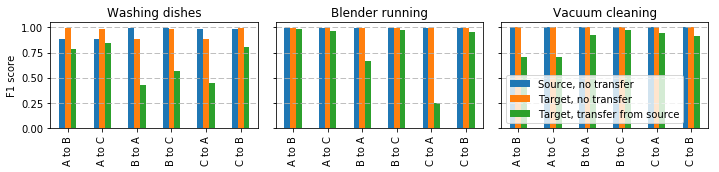

In [243]:
def rename_labels(df_plot, column):
    df_plot = df_plot.copy()
    df_plot[column] = df_plot[column].replace('Coffee', 'C')
    df_plot[column] = df_plot[column].replace('Sink', 'B')
    df_plot[column] = df_plot[column].replace('Table', 'A')
    return df_plot

plt.rcParams["figure.figsize"] = (10, 2.5)
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

_df = df.loc[df.type_of_transfer == 'Same room, different place']
_df = rename_labels(_df, 'source_placement')
_df = rename_labels(_df, 'target_placement')
_df = _df.loc[_df.classifier == 'SVM']
_df = _df.loc[_df.features_name == 'All']
_df = _df.loc[_df.source_room == 'synergy']
_df['transfer'] = _df['source_placement'] + ' to ' + _df['target_placement']

__df = _df.loc[_df.label == 'Dishes']
pd.DataFrame({
    'Source, no transfer': __df.groupby(['transfer'])['f1_wt'].mean(),
    'Target, transfer from source': __df.groupby(['transfer'])['f1'].mean(),
    'Target, no transfer': __df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar(ax=axes[0])
axes[0].yaxis.grid(linestyle='dashed',)
matplotlib.pyplot.sca(axes[0])
plt.title('Washing dishes')
plt.legend().remove()
plt.xlabel('')
plt.ylabel('F1 score')

__df = _df.loc[_df.label == 'Blender running']
pd.DataFrame({
    'Source, no transfer': __df.groupby(['transfer'])['f1_wt'].mean(),
    'Target, transfer from source': __df.groupby(['transfer'])['f1'].mean(),
    'Target, no transfer': __df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar(ax=axes[1])
axes[1].yaxis.grid(linestyle='dashed',)
matplotlib.pyplot.sca(axes[1])
plt.title('Blender running')
plt.legend().remove()
plt.xlabel('')

__df = _df.loc[_df.label == 'Vacuum cleaning']
pd.DataFrame({
    'Source, no transfer': __df.groupby(['transfer'])['f1_wt'].mean(),
    'Target, transfer from source': __df.groupby(['transfer'])['f1'].mean(),
    'Target, no transfer': __df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar(ax=axes[2])
axes[2].yaxis.grid(linestyle='dashed',)
matplotlib.pyplot.sca(axes[2])
plt.title('Vacuum cleaning')
plt.legend(loc=3)
plt.xlabel('')

plt.tight_layout()
plt.savefig('../plots/placement_change_effect.pdf')
plt.show()

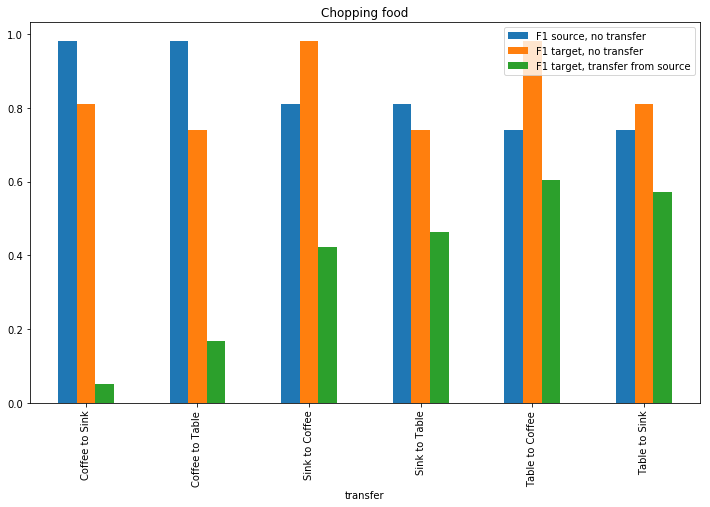

In [62]:
_df = df.loc[df.type_of_transfer == 'Same room, different place']
_df = _df.loc[_df.classifier == 'SVM']
_df = _df.loc[_df.features_name == 'All']
_df = _df.loc[_df.label == 'Chopping food']
_df = _df.loc[_df.source_room == 'synergy']
_df['transfer'] = df['source_placement'] + ' to ' + df['target_placement']
pd.DataFrame({
    'F1 source, no transfer': _df.groupby(['transfer'])['f1_wt'].mean(),
    'F1 target, transfer from source': _df.groupby(['transfer'])['f1'].mean(),
    'F1 target, no transfer': _df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar()
plt.title('Chopping food')

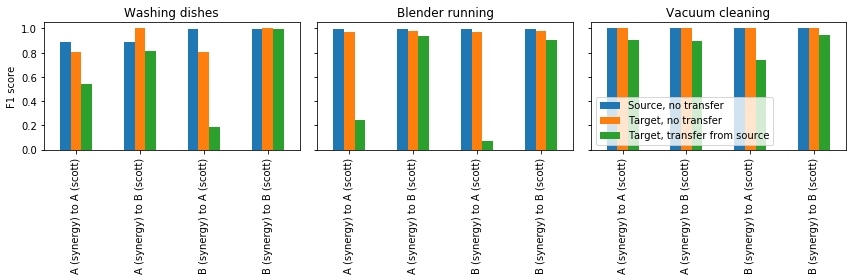

In [232]:
def rename_labels(df_plot, column):
    df_plot = df_plot.copy()
    df_plot[column] = df_plot[column].replace('Coffee', 'C')
    df_plot[column] = df_plot[column].replace('Sink', 'B')
    df_plot[column] = df_plot[column].replace('Table', 'A')
    df_plot[column] = df_plot[column].replace('Left', 'B')
    df_plot[column] = df_plot[column].replace('Right', 'C')
    df_plot[column] = df_plot[column].replace('Pantry', 'A')
    return df_plot

plt.rcParams["figure.figsize"] = (12, 4)
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

_df = df.loc[df.type_of_transfer == 'Different room']
_df = _df.loc[_df.classifier == 'SVM']
_df = _df.loc[_df.features_name == 'All']
_df = _df.loc[_df.source_room.isin(['synergy'])]
_df = _df.loc[_df.target_room.isin(['scott'])]
_df = _df.loc[_df.source_placement.isin(['Sink', 'Table'])]
_df = _df.loc[_df.target_placement.isin(['Left', 'Pantry'])]
_df = rename_labels(_df, 'target_placement')
_df = rename_labels(_df, 'source_placement')
_df['transfer'] = _df['source_placement'] + ' (' + _df['source_room'] + ') to ' + _df['target_placement'] + ' (' + _df['target_room'] + ')'



__df = _df.loc[_df.label == 'Dishes']
pd.DataFrame({
    'Source, no transfer': __df.groupby(['transfer'])['f1_wt'].mean(),
    'Target, transfer from source': __df.groupby(['transfer'])['f1'].mean(),
    'Target, no transfer': __df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar(ax=axes[0])
matplotlib.pyplot.sca(axes[0])
plt.title('Washing dishes')
plt.legend().remove()
plt.xlabel('')
plt.ylabel('F1 score')

__df = _df.loc[_df.label == 'Blender running']
pd.DataFrame({
    'Source, no transfer': __df.groupby(['transfer'])['f1_wt'].mean(),
    'Target, transfer from source': __df.groupby(['transfer'])['f1'].mean(),
    'Target, no transfer': __df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar(ax=axes[1])
matplotlib.pyplot.sca(axes[1])
plt.title('Blender running')
plt.legend().remove()
plt.xlabel('')

__df = _df.loc[_df.label == 'Vacuum cleaning']
pd.DataFrame({
    'Source, no transfer': __df.groupby(['transfer'])['f1_wt'].mean(),
    'Target, transfer from source': __df.groupby(['transfer'])['f1'].mean(),
    'Target, no transfer': __df.groupby(['transfer'])['f1_target_wt'].mean()
}).plot.bar(ax=axes[2])
matplotlib.pyplot.sca(axes[2])
plt.title('Vacuum cleaning')
plt.legend(loc=3)
plt.xlabel('')

plt.tight_layout()
plt.savefig('../plots/placements_across_rooms_effect.pdf')
plt.show()

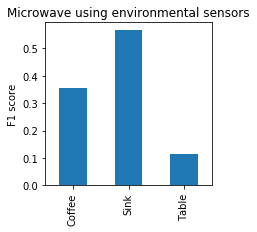

In [178]:
plt.rcParams["figure.figsize"] = (3, 3)
_df = df_no_transfer
_df = _df.loc[_df.classifier == 'SVM']
_df = _df.loc[_df.features_name == 'Environmental']
_df = _df.loc[_df.source_room == 'synergy']
# _df = _df.loc[_df.source_dataset == 'synergy-final-iter1']
_df = _df.loc[_df.label == 'Microwave']
# _df['transfer'] = _df['source_placement'] + ' to ' + _df['target_placement']
_df.groupby(['source_placement'])['f1'].mean().plot.bar()
plt.title('Microwave using environmental sensors')
plt.ylabel('F1 score')
plt.xlabel('')